## This notebook required GPU and should be run within ChromBPNet docker environment

In [ ]:
### These environments are installed within docker: 
!pip install jupyterlab
!pip install pysam
!conda install -c bioconda pandas -y
!conda install -c bioconda logomaker -y 
!conda install -c bioconda seaborn -y 
!pip install hdf5plugin

In [ ]:
## Load packages 
import tensorflow as tf
import numpy as np
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
import logomaker
from copy import deepcopy
from tqdm import tqdm
from tqdm import tnrange
import pyBigWig
import tqdm
import sys
import pyfaidx
sys.path.append("../../../chrombpnet/")
from training.utils.losses import multinomial_nll
from training.utils.one_hot import dna_to_one_hot
from evaluation.interpret.shap_utils import *
import shap
import glob
tf.compat.v1.disable_eager_execution()
from scipy.spatial.distance import jensenshannon
from numpy.linalg import norm
from scipy.stats import wasserstein_distance
import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib
import hdf5plugin
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import h5py
import pyBigWig
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import sys
sys.path.append("../../../src/")
custom_objects={"tf":tf, "multinomial_nll":multinomial_nll}    
get_custom_objects().update(custom_objects)
from tensorflow import keras
import deepdish as dd
from scipy.stats import pearsonr
from scipy.stats import spearmanr

## Functions

In [ ]:
### Required functions 
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [ ]:
def dna_to_one_hot(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(np.int8)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))

In [ ]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [ ]:
def generate_shap_dict(seqs, scores):
    print(seqs.shape, scores.shape)
    assert(seqs.shape==scores.shape)
    assert(seqs.shape[2]==4)

    # construct a dictionary for the raw shap scores and the
    # the projected shap scores
    # MODISCO workflow expects one hot sequences with shape (None,4,inputlen)
    d = {
            'raw': {'seq': np.transpose(seqs, (0, 2, 1))},
            'shap': {'seq': np.transpose(scores, (0, 2, 1))},
            'projected_shap': {'seq': np.transpose(seqs*scores, (0, 2, 1))}
        }

    return d

In [ ]:
from deeplift.dinuc_shuffle import dinuc_shuffle

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    
    for l in [0]:
        projected_hypothetical_contribs = \
            np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        
        # At each position in the input sequence, we iterate over the
        # one-hot encoding possibilities (eg: for genomic sequence, 
        # this is ACGT i.e. 1000, 0100, 0010 and 0001) and compute the
        # hypothetical difference-from-reference in each case. We then 
        # multiply the hypothetical differences-from-reference with 
        # the multipliers to get the hypothetical contributions. For 
        # each of the one-hot encoding possibilities, the hypothetical
        # contributions are then summed across the ACGT axis to 
        # estimate the total hypothetical contribution of each 
        # position. This per-position hypothetical contribution is then
        # assigned ("projected") onto whichever base was present in the
        # hypothetical sequence. The reason this is a fast estimate of
        # what the importance scores *would* look like if different 
        # bases were present in the underlying sequence is that the
        # multipliers are computed once using the original sequence, 
        # and are not computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:, i] = 1.0
            hypothetical_difference_from_reference = \
                (hypothetical_input[None, :, :] - bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference * \
                                    mult[l]
            projected_hypothetical_contribs[:, :, i] = \
                np.sum(hypothetical_contribs, axis=-1) 
            
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))

    if len(orig_inp)>1:
        to_return.append(np.zeros_like(orig_inp[1]))
    
    return to_return


def shuffle_several_times(s):
    numshuffles=20
    if len(s)==2:
        return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
                np.array([s[1] for i in range(numshuffles)])]
    else:
        return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)])]

In [ ]:
def get_weightedsum_meannormed_logits(model):
    # Assumes the 0 task track is for profile
    # See Google slide deck for explanations
    # We meannorm as per section titled 
    # "Adjustments for Softmax Layers" in the DeepLIFT paper
    meannormed_logits = (model.outputs[0] - \
                         tf.reduce_mean(model.outputs[0], axis=1)[:, None])

    # 'stop_gradient' will prevent importance from being propagated
    # through this operation; we do this because we just want to treat
    # the post-softmax probabilities as 'weights' on the different 
    # logits, without having the network explain how the probabilities
    # themselves were derived. Could be worth contrasting explanations
    # derived with and without stop_gradient enabled...
    stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
    softmax_out = tf.nn.softmax(stopgrad_meannormed_logits, axis=1)
    
    # Weight the logits according to the softmax probabilities, take
    # the sum for each example. This mirrors what was done for the
    # bpnet paper.
    weightedsum_meannormed_logits = tf.reduce_sum(softmax_out * \
                                                  meannormed_logits,
                                                  axis=1)
    
    return weightedsum_meannormed_logits

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def ic_scale(pwm,background):
    odds_ratio = ((pwm+0.001)/(1.004))/(background[None,:])
    ic = ((np.log((pwm+0.001)/(1.004))/np.log(2))*pwm -\
            (np.log(background)*background/np.log(2))[None,:])
    return pwm*(np.sum(ic,axis=1)[:,None])


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(matplotlib.patches.Polygon((np.array([1,height])[None,:]*polygon_coords
                                                 + np.array([left_edge,base])[None,:]),
                                                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.825, base+0.085*height], width=0.174, height=0.415*height,
                                            facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.625, base+0.35*height], width=0.374, height=0.15*height,
                                            facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
                  width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
                  width=1.0, height=0.2*height, facecolor=color, edgecolor=color, fill=True))

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
def plot_weights_given_ax(ax, array,
                 height_padding_factor,
                 length_padding,
                 subticks_frequency,
                 highlight,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 ylabel="",
                 ylim=None):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))

    if ylim is not None:
        # Use user-specified y-axis limits
        min_neg_height, max_pos_height = ylim
        assert min_neg_height <= 0
        assert max_pos_height >= 0

    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=1.0,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={},
                 ylabel="",
                 ylim=None,
                 filename=None,
                 return_fig=False):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight,
        ylabel=ylabel,
        ylim=ylim)
    plt.ylim(ylim)
    plt.savefig(filename,format="svg")

    if return_fig:
        return fig
    plt.show()

In [ ]:
def calculate_correlations(array1, array2):
    correlations = np.zeros(array1.shape[0])
    
    for i in range(array1.shape[0]):
        corr, _ = pearsonr(array1[i], array2[i])
        correlations[i] = corr
    
    return correlations

In [ ]:
from collections import Counter

def find_common_peaks(peaks):
    # Count occurrences of each peak
    peak_counts = Counter(peaks)

    # Filter peaks that occur at least twice
    common_peaks = [peak for peak, count in peak_counts.items() if count >= 2]

    return common_peaks


def merge_lists(lists):
    merged_list = []
    for lst in lists:
        merged_list.extend(lst)
    return merged_list

In [ ]:
def generate_onehot_sequences(genome_fasta_path,peaks_with_summit):
    ref = pyfaidx.Fasta(genome_fasta_path)
    INPUT_LEN = 2114
    sequences = []
    buffer = 500
    for i,x in peaks_with_summit.iterrows():
        sequence = str(ref[x['peak_chrom']][((x['peak_start'] + x['summit']) - INPUT_LEN//2):((x['peak_start'] + x['summit']) + INPUT_LEN//2)])
        if len(sequence)==2114:
            sequence = sequence[:INPUT_LEN]
            sequences.append(sequence)
        else: 
        print(i)
    onehot_seq = []
    for i in range(len(sequences)):
        onehot_seq.append(dna_to_one_hot(sequences[i]).reshape(1,-1,4))

    onehot_seq = np.concatenate( onehot_seq, axis=0 )
    print(onehot_seq.shape)
    return onehot_seq

In [ ]:
input_len = 2114
start = np.int(input_len/2 - 500)
end = np.int(input_len/2 + 500)
def compute_and_save_shap_scores(species_model,onehot_seq):
    model_profile_explainers = shap.explainers.deep.TFDeepExplainer(
    (species_model.input, get_weightedsum_meannormed_logits(species_model)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
    profile_shap_scores = np.array(model_profile_explainers.shap_values(
    onehot_seq, progress_message=200))
    profile_shap_scores_dict = generate_shap_dict(onehot_seq, profile_shap_scores)
    profile_shap_scores_dict = profile_shap_scores_dict['projected_shap']['seq'][:]
    profile_shap_scores_dict = profile_shap_scores_dict.transpose(0,2,1)
    profile_shap_scores_dict = np.sum(profile_shap_scores_dict,axis=2)
    profile_shap_scores_dict = profile_shap_scores_dict[:,start:end]
    return profile_shap_scores_dict

In [308]:
def min_max_normalize_rows(df):
    # Copy the original DataFrame to avoid modifying the original data
    normalized_df = df.copy()
    
    # Iterate over each row
    for index, row in df.iterrows():
        # Calculate min and max values for the row
        min_value = row.min()
        max_value = row.max()
        
        # Perform min-max normalization for the row
        normalized_row = (row - min_value) / (max_value - min_value)
        
        # Update the normalized row in the new DataFrame
        normalized_df.loc[index] = normalized_row
    
    return normalized_df

### Loading models 

In [ ]:
# Let's now load the two models and run the difference
with tf.keras.utils.CustomObjectScope({'multinomial_null':multinomial_nll, 'tf':tf}):
    Sman_neural = keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/neural/neural_chrombpnet_wo_bias.h5")
    Sman_cathepsin = keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/cathepsin/cathepsin_chrombpnet_wo_bias.h5")
    Sman_intestine = keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/intestine/intestine_chrombpnet_wo_bias.h5")
    Sman_muscle = keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/muscle/muscle_chrombpnet_wo_bias.h5")
    Sman_tegument = keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/tegument/tegument_chrombpnet_wo_bias.h5")
    
    Smed_neural = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/neural/neural_chrombpnet_wo_bias.h5")
    Smed_cathepsin = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/cathepsin/cathepsin_chrombpnet_wo_bias.h5")
    Smed_epidermal = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/epidermal/epidermal_chrombpnet_wo_bias.h5")
    Smed_intestine = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/intestine/intestine_chrombpnet_wo_bias.h5")
    Smed_muscle = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/muscle/muscle_chrombpnet_wo_bias.h5")
    Smed_parenchyma = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/parenchyma/parenchyma_chrombpnet_wo_bias.h5")

## Sman peaks interpreted by Smed models

In [ ]:
### Loading marker peaks for each cell type 
neural_peaks = pd.read_csv("./ChromBPNet/Peaks/schisto_Neural_final.csv",index_col=0)
muscle_peaks = pd.read_csv("./ChromBPNet/Peaks/schisto_Muscle_final.csv",index_col=0)
intestine_peaks = pd.read_csv("./ChromBPNet/Peaks/schisto_intestine_final.csv",index_col=0)
epidermal_peaks = pd.read_csv("./ChromBPNet/Peaks/schisto_Epidermal_final.csv",index_col=0)
cathepsin_peaks = pd.read_csv("./ChromBPNet/Peaks/schisto_cathepsin_final.csv",index_col=0)

# Remove common peaks overlapping between cell types 
all_peaks = [neural_peaks.Peak.tolist(), muscle_peaks.Peak.tolist(), intestine_peaks.Peak.tolist(),
             epidermal_peaks.Peak.tolist(), cathepsin_peaks.Peak.tolist()]
all_peaks = merge_lists(all_peaks)
common_peaks = find_common_peaks(all_peaks)

In [ ]:
neural_peaks= neural_peaks[~neural_peaks.Peak.isin(common_peaks)]
muscle_peaks= muscle_peaks[~muscle_peaks.Peak.isin(common_peaks)]
intestine_peaks= intestine_peaks[~intestine_peaks.Peak.isin(common_peaks)]
epidermal_peaks= epidermal_peaks[~epidermal_peaks.Peak.isin(common_peaks)]
cathepsin_peaks= cathepsin_peaks[~cathepsin_peaks.Peak.isin(common_peaks)]


In [ ]:
# First let's split the peak into chr, start, and end
neural_peaks[['chr', 'start', 'end']] = neural_peaks['Peak'].str.split(':|-', expand=True)
muscle_peaks[['chr', 'start', 'end']] = muscle_peaks['Peak'].str.split(':|-', expand=True) 
intestine_peaks[['chr', 'start', 'end']] = intestine_peaks['Peak'].str.split(':|-', expand=True)
epidermal_peaks[['chr', 'start', 'end']] = epidermal_peaks['Peak'].str.split(':|-', expand=True) 
cathepsin_peaks[['chr', 'start', 'end']] = cathepsin_peaks['Peak'].str.split(':|-', expand=True)

In [ ]:
### Here, I should add summit value so that I can do prediction 
allpeaks = pd.read_csv("./Peaks/Sman.merged_peaks.narrowPeak", sep="\t",header=None)
allpeaks.columns = ['chr','start','end','peak_index','score','strand','X','Y','Z','summit']
allpeaks =  allpeaks[['chr','start','end','summit']]
allpeaks['Peak'] = allpeaks.chr + ':' + (allpeaks.start+1).astype(str) + '-' + allpeaks.end.astype(str)
allpeaks['start'] = allpeaks['start']+1
allpeaks

In [ ]:
neural_peaks_summit = pd.merge(neural_peaks,allpeaks,on=['Peak'],how='left')
muscle_peaks_summit = pd.merge(muscle_peaks,allpeaks,on=['Peak'],how='left')
intestine_peaks_summit = pd.merge(intestine_peaks,allpeaks,on=['Peak'],how='left')
epidermal_peaks_summit = pd.merge(epidermal_peaks,allpeaks,on=['Peak'],how='left')
cathepsin_peaks_summit = pd.merge(cathepsin_peaks,allpeaks,on=['Peak'],how='left')

In [ ]:
epidermal_peaks_summit

In [ ]:
### Need to drop peaks on edges as models won't be able to interpret; index number that get drops here and didn't meet input length criteria is obtained from the cell below
neural_peaks_summit = neural_peaks_summit [['chr_y','start_y','end_y','summit','prob_da','effect_size','Peak','is_da_fdr']]
neural_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','prob_da','effect_size','Peak','is_da_fdr']
neural_index = [310,5192]
neural_peaks_summit= neural_peaks_summit.drop(neural_index)

muscle_peaks_summit = muscle_peaks_summit [['chr_y','start_y','end_y','summit','prob_da','effect_size','Peak','is_da_fdr']]
muscle_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','prob_da','effect_size','Peak','is_da_fdr']

intestine_peaks_summit = intestine_peaks_summit [['chr_y','start_y','end_y','summit','prob_da','effect_size','Peak','is_da_fdr']]
intestine_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','prob_da','effect_size','Peak','is_da_fdr']
intestine_index = [2120]
intestine_peaks_summit= intestine_peaks_summit.drop(intestine_index)

epidermal_peaks_summit = epidermal_peaks_summit [['chr_y','start_y','end_y','summit','prob_da','effect_size','Peak','is_da_fdr']]
epidermal_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','prob_da','effect_size','Peak','is_da_fdr']
epidermal_index = [432,3856,4741]
epidermal_peaks_summit= epidermal_peaks_summit.drop(epidermal_index)

cathepsin_peaks_summit = cathepsin_peaks_summit [['chr_y','start_y','end_y','summit','prob_da','effect_size','Peak','is_da_fdr']]
cathepsin_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','prob_da','effect_size','Peak','is_da_fdr']
cathepsin_index = [72,312,420,749,3472,3698,3808]
cathepsin_peaks_summit= cathepsin_peaks_summit.drop(cathepsin_index)

## Schisto neural peaks 

In [ ]:
Sman_neural_onehot_seq = generate_onehot_sequences('./Refs/SM_V7/Schisto_PRJEA36577.WBPS15.genomic.fa',neural_peaks_summit)

In [ ]:
Sman_neural = Sman_neural.predict(Sman_neural_onehot_seq)
Smed_neural = Smed_neural.predict(Sman_neural_onehot_seq)
Smed_cathepsin = Smed_cathepsin.predict(Sman_neural_onehot_seq)
Smed_epidermal = Smed_epidermal.predict(Sman_neural_onehot_seq)
Smed_intestine = Smed_intestine.predict(Sman_neural_onehot_seq)
Smed_muscle = Smed_muscle.predict(Sman_neural_onehot_seq)


In [ ]:
Sman_neural_logits, Sman_neural_counts = Sman_neural
Smed_neural_logits, Smed_neural_counts = Smed_neural
Smed_cathepsin_logits, Smed_cathepsin_counts = Smed_cathepsin
Smed_epidermal_logits, Smed_epidermal_counts = Smed_epidermal
Smed_intestine_logits, Smed_intestine_counts = Smed_intestine
Smed_muscle_logits, Smed_muscle_counts = Smed_muscle

Sman_neural_probs = softmax(Sman_neural_logits)
Smed_neural_probs = softmax(Smed_neural_logits)   
Smed_cathepsin_probs = softmax(Smed_cathepsin_logits)
Smed_epidermal_probs = softmax(Smed_epidermal_logits) 
Smed_intestine_probs = softmax(Smed_intestine_logits) 
Smed_muscle_probs = softmax(Smed_muscle_logits)

In [ ]:
corr_neural = calculate_correlations(Sman_neural_probs, Smed_neural_probs)
corr_muscle = calculate_correlations(Sman_neural_probs, Smed_muscle_probs)
corr_intestine = calculate_correlations(Sman_neural_probs, Smed_intestine_probs)
corr_cathepsin = calculate_correlations(Sman_neural_probs, Smed_cathepsin_probs )
corr_epidermal= calculate_correlations(Sman_neural_probs, Smed_epidermal_probs )

In [ ]:
Sman_neural_df = {'corr_neural': corr_neural, 'corr_muscle': corr_muscle, 'corr_intestine': corr_intestine, 'corr_cathepsin': corr_cathepsin,
                   'corr_epidermal': corr_epidermal}
Sman_neural_df = pd.DataFrame(Sman_neural_df)

In [ ]:
## Interpreting the profiles predictions 
Sman_neural_SHAP = compute_and_save_shap_scores(Sman_neural, Sman_neural_onehot_seq)
Smed_neural_SHAP = compute_and_save_shap_scores(Smed_neural, Sman_neural_onehot_seq)
Smed_muscle_SHAP = compute_and_save_shap_scores(Smed_muscle, Sman_neural_onehot_seq)
Smed_intestine_SHAP = compute_and_save_shap_scores(Smed_intestine, Sman_neural_onehot_seq)
Smed_cathepsin_SHAP = compute_and_save_shap_scores(Smed_cathepsin, Sman_neural_onehot_seq)
Smed_epidermal_SHAP = compute_and_save_shap_scores(Smed_epidermal, Sman_neural_onehot_seq)

In [ ]:
corr_neural_SHAP = calculate_correlations(Sman_neural_SHAP, Smed_neural_SHAP)
corr_muscle_SHAP = calculate_correlations(Sman_neural_SHAP, Smed_muscle_SHAP)
corr_intestine_SHAP = calculate_correlations(Sman_neural_SHAP, Smed_intestine_SHAP)
corr_cathepsin_SHAP = calculate_correlations(Sman_neural_SHAP, Smed_cathepsin_SHAP)
corr_epidermal_SHAP= calculate_correlations(Sman_neural_SHAP, Smed_epdiermal_SHAP)

In [ ]:
Sman_neural_SHAP_df = {'corr_neural_SHAP': corr_neural_SHAP, 
                       'corr_muscle_SHAP': corr_muscle_SHAP, 
                       'corr_intestine_SHAP': corr_intestine_SHAP,
                       'corr_cathepsin_SHAP': corr_cathepsin_SHAP,
                       'corr_epidermal_SHAP': corr_epidermal_SHAP}
Sman_neural_SHAP_df = pd.DataFrame(Sman_neural_SHAP_df)
Sman_neural_all = pd.concat([Sman_neural_df,Sman_neural_SHAP_df],axis=1)
Sman_neural_all.to_csv("./ChromBPNet/cross_species_correlation/Sman_peaks/neural_peaks_withallinfo_filtered.csv", sep="\t",index=False) # change the path 

## Schisto muscle peaks

In [ ]:
Sman_muscle_onehot_seq = generate_onehot_sequences('./Refs/SM_V7/Schisto_PRJEA36577.WBPS15.genomic.fa',muscle_peaks_summit)

In [ ]:
Sman_muscle = Sman_muscle.predict(Sman_muscle_onehot_seq)
Smed_neural = Smed_neural.predict(Sman_muscle_onehot_seq)
Smed_cathepsin = Smed_cathepsin.predict(Sman_muscle_onehot_seq)
Smed_epidermal = Smed_epidermal.predict(Sman_muscle_onehot_seq)
Smed_intestine = Smed_intestine.predict(Sman_muscle_onehot_seq)
Smed_muscle = Smed_muscle.predict(Sman_muscle_onehot_seq)


In [ ]:
Sman_muscle_logits, Sman_muscle_counts = Sman_muscle
Smed_neural_logits, Smed_neural_counts = Smed_neural
Smed_cathepsin_logits, Smed_cathepsin_counts = Smed_cathepsin
Smed_epidermal_logits, Smed_epidermal_counts = Smed_epidermal
Smed_intestine_logits, Smed_intestine_counts = Smed_intestine
Smed_muscle_logits, Smed_muscle_counts = Smed_muscle

Sman_muscle_probs = softmax(Sman_muscle_logits)
Smed_neural_probs = softmax(Smed_neural_logits)   
Smed_cathepsin_probs = softmax(Smed_cathepsin_logits)
Smed_epidermal_probs = softmax(Smed_epidermal_logits) 
Smed_intestine_probs = softmax(Smed_intestine_logits) 
Smed_muscle_probs = softmax(Smed_muscle_logits)

In [ ]:
corr_neural = calculate_correlations(Sman_muscle_probs, Smed_neural_probs)
corr_muscle = calculate_correlations(Sman_muscle_probs, Smed_muscle_probs)
corr_intestine = calculate_correlations(Sman_muscle_probs, Smed_intestine_probs)
corr_cathepsin = calculate_correlations(Sman_muscle_probs, Smed_cathepsin_probs )
corr_epidermal= calculate_correlations(Sman_muscle_probs, Smed_epidermal_probs )

In [ ]:
Sman_muscle_df = {'corr_neural': corr_neural, 'corr_muscle': corr_muscle, 'corr_intestine': corr_intestine, 'corr_cathepsin': corr_cathepsin,
                   'corr_epidermal': corr_epidermal}
Sman_muscle_df = pd.DataFrame(Sman_muscle_df)

In [ ]:
## Interpreting the profiles predictions 
Sman_muscle_SHAP = compute_and_save_shap_scores(Sman_muscle, Sman_muscle_onehot_seq)
Smed_neural_SHAP = compute_and_save_shap_scores(Smed_neural, Sman_muscle_onehot_seq)
Smed_muscle_SHAP = compute_and_save_shap_scores(Smed_muscle, Sman_muscle_onehot_seq)
Smed_intestine_SHAP = compute_and_save_shap_scores(Smed_intestine, Sman_muscle_onehot_seq)
Smed_cathepsin_SHAP = compute_and_save_shap_scores(Smed_cathepsin, Sman_muscle_onehot_seq)
Smed_epidermal_SHAP = compute_and_save_shap_scores(Smed_epidermal, Sman_muscle_onehot_seq)

In [ ]:
corr_neural_SHAP = calculate_correlations(Sman_muscle_SHAP, Smed_neural_SHAP)
corr_muscle_SHAP = calculate_correlations(Sman_muscle_SHAP, Smed_muscle_SHAP)
corr_intestine_SHAP = calculate_correlations(Sman_muscle_SHAP, Smed_intestine_SHAP)
corr_cathepsin_SHAP = calculate_correlations(Sman_muscle_SHAP, Smed_cathepsin_SHAP)
corr_epidermal_SHAP= calculate_correlations(Sman_muscle_SHAP, Smed_epdiermal_SHAP)

In [ ]:
Sman_muscle_SHAP_df = {'corr_neural_SHAP': corr_neural_SHAP, 
                       'corr_muscle_SHAP': corr_muscle_SHAP, 
                       'corr_intestine_SHAP': corr_intestine_SHAP,
                       'corr_cathepsin_SHAP': corr_cathepsin_SHAP,
                       'corr_epidermal_SHAP': corr_epidermal_SHAP}
Sman_muscle_SHAP_df = pd.DataFrame(Sman_muscle_SHAP_df)
Sman_muscle_all = pd.concat([Sman_muscle_df,Sman_muscle_SHAP_df],axis=1)
Sman_muscle_all.to_csv("./ChromBPNet/cross_species_correlation/Sman_peaks/muscle_peaks_withallinfo_filtered.csv", sep="\t",index=False) # change the path 

## Schisto intestine peaks

In [ ]:
Sman_intestine_onehot_seq = generate_onehot_sequences('./Refs/SM_V7/Schisto_PRJEA36577.WBPS15.genomic.fa',intestine_peaks_summit)

In [ ]:
Sman_intestine = Sman_muscle.predict(Sman_intestine_onehot_seq)
Smed_neural = Smed_neural.predict(Sman_intestine_onehot_seq)
Smed_cathepsin = Smed_cathepsin.predict(Sman_intestine_onehot_seq)
Smed_epidermal = Smed_epidermal.predict(Sman_intestine_onehot_seq)
Smed_intestine = Smed_intestine.predict(Sman_intestine_onehot_seq)
Smed_muscle = Smed_muscle.predict(Sman_intestine_onehot_seq)


In [ ]:
Sman_intestine_logits, Sman_intestine_counts = Sman_intestine
Smed_neural_logits, Smed_neural_counts = Smed_neural
Smed_cathepsin_logits, Smed_cathepsin_counts = Smed_cathepsin
Smed_epidermal_logits, Smed_epidermal_counts = Smed_epidermal
Smed_intestine_logits, Smed_intestine_counts = Smed_intestine
Smed_muscle_logits, Smed_muscle_counts = Smed_muscle

Sman_intestine_probs = softmax(Sman_intestine_logits)
Smed_neural_probs = softmax(Smed_neural_logits)   
Smed_cathepsin_probs = softmax(Smed_cathepsin_logits)
Smed_epidermal_probs = softmax(Smed_epidermal_logits) 
Smed_intestine_probs = softmax(Smed_intestine_logits) 
Smed_muscle_probs = softmax(Smed_muscle_logits)

In [ ]:
corr_neural = calculate_correlations(Sman_intestine_probs, Smed_neural_probs)
corr_muscle = calculate_correlations(Sman_intestine_probs, Smed_muscle_probs)
corr_intestine = calculate_correlations(Sman_intestine_probs, Smed_intestine_probs)
corr_cathepsin = calculate_correlations(Sman_intestine_probs, Smed_cathepsin_probs )
corr_epidermal= calculate_correlations(Sman_intestine_probs, Smed_epidermal_probs )

In [ ]:
Sman_intestine_df = {'corr_neural': corr_neural, 'corr_muscle': corr_muscle, 'corr_intestine': corr_intestine, 'corr_cathepsin': corr_cathepsin,
                   'corr_epidermal': corr_epidermal}
Sman_intestine_df = pd.DataFrame(Sman_intestine_df)

In [ ]:
## Interpreting the profiles predictions 
Sman_intestine_SHAP = compute_and_save_shap_scores(Sman_intestine, Sman_intestine_onehot_seq)
Smed_neural_SHAP = compute_and_save_shap_scores(Smed_neural, Sman_intestine_onehot_seq)
Smed_muscle_SHAP = compute_and_save_shap_scores(Smed_muscle, Sman_intestine_onehot_seq)
Smed_intestine_SHAP = compute_and_save_shap_scores(Smed_intestine, Sman_intestine_onehot_seq)
Smed_cathepsin_SHAP = compute_and_save_shap_scores(Smed_cathepsin, Sman_intestine_onehot_seq)
Smed_epidermal_SHAP = compute_and_save_shap_scores(Smed_epidermal, Sman_intestine_onehot_seq)

In [ ]:
corr_neural_SHAP = calculate_correlations(Sman_intestine_SHAP, Smed_neural_SHAP)
corr_muscle_SHAP = calculate_correlations(Sman_intestine_SHAP, Smed_muscle_SHAP)
corr_intestine_SHAP = calculate_correlations(Sman_intestine_SHAP, Smed_intestine_SHAP)
corr_cathepsin_SHAP = calculate_correlations(Sman_intestine_SHAP, Smed_cathepsin_SHAP)
corr_epidermal_SHAP= calculate_correlations(Sman_intestine_SHAP, Smed_epdiermal_SHAP)

In [ ]:
Sman_intestine_SHAP_df = {'corr_neural_SHAP': corr_neural_SHAP, 
                       'corr_muscle_SHAP': corr_muscle_SHAP, 
                       'corr_intestine_SHAP': corr_intestine_SHAP,
                       'corr_cathepsin_SHAP': corr_cathepsin_SHAP,
                       'corr_epidermal_SHAP': corr_epidermal_SHAP}
Sman_intestine_SHAP_df = pd.DataFrame(Sman_intestine_SHAP_df)
Sman_intestine_all = pd.concat([Sman_intestine_df,Sman_intestine_SHAP_df],axis=1)
Sman_intestine_all.to_csv("./ChromBPNet/cross_species_correlation/Sman_peaks/intestine_peaks_withallinfo_filtered.csv", sep="\t",index=False) # change the path 

## schisto cathepsin peaks

In [ ]:
Sman_cathepsin_onehot_seq = generate_onehot_sequences('./Refs/SM_V7/Schisto_PRJEA36577.WBPS15.genomic.fa',cathepsin_peaks_summit)

In [ ]:
Sman_cathepsin = Sman_muscle.predict(Sman_cathepsin_onehot_seq)
Smed_neural = Smed_neural.predict(Sman_cathepsin_onehot_seq)
Smed_cathepsin = Smed_cathepsin.predict(Sman_cathepsin_onehot_seq)
Smed_epidermal = Smed_epidermal.predict(Sman_cathepsin_onehot_seq)
Smed_intestine = Smed_intestine.predict(Sman_cathepsin_onehot_seq)
Smed_muscle = Smed_muscle.predict(Sman_cathepsin_onehot_seq)


In [ ]:
Sman_cathepsin_logits, Sman_cathepsin_counts = Sman_cathepsin
Smed_neural_logits, Smed_neural_counts = Smed_neural
Smed_cathepsin_logits, Smed_cathepsin_counts = Smed_cathepsin
Smed_epidermal_logits, Smed_epidermal_counts = Smed_epidermal
Smed_intestine_logits, Smed_intestine_counts = Smed_intestine
Smed_muscle_logits, Smed_muscle_counts = Smed_muscle

Sman_cathepsin_probs = softmax(Sman_cathepsin_logits)
Smed_neural_probs = softmax(Smed_neural_logits)   
Smed_cathepsin_probs = softmax(Smed_cathepsin_logits)
Smed_epidermal_probs = softmax(Smed_epidermal_logits) 
Smed_intestine_probs = softmax(Smed_intestine_logits) 
Smed_muscle_probs = softmax(Smed_muscle_logits)

In [ ]:
corr_neural = calculate_correlations(Sman_cathepsin_probs, Smed_neural_probs)
corr_muscle = calculate_correlations(Sman_cathepsin_probs, Smed_muscle_probs)
corr_intestine = calculate_correlations(Sman_cathepsin_probs, Smed_intestine_probs)
corr_cathepsin = calculate_correlations(Sman_cathepsin_probs, Smed_cathepsin_probs )
corr_epidermal= calculate_correlations(Sman_cathepsin_probs, Smed_epidermal_probs )

In [ ]:
Sman_cathepsin_df = {'corr_neural': corr_neural, 'corr_muscle': corr_muscle, 'corr_intestine': corr_intestine, 'corr_cathepsin': corr_cathepsin,
                   'corr_epidermal': corr_epidermal}
Sman_cathepsin_df = pd.DataFrame(Sman_cathepsin_df)

In [ ]:
## Interpreting the profiles predictions 
Sman_cathepsin_SHAP = compute_and_save_shap_scores(Sman_cathepsin, Sman_cathepsin_onehot_seq)
Smed_neural_SHAP = compute_and_save_shap_scores(Smed_neural, Sman_cathepsin_onehot_seq)
Smed_muscle_SHAP = compute_and_save_shap_scores(Smed_muscle, Sman_cathepsin_onehot_seq)
Smed_intestine_SHAP = compute_and_save_shap_scores(Smed_intestine, Sman_cathepsin_onehot_seq)
Smed_cathepsin_SHAP = compute_and_save_shap_scores(Smed_cathepsin, Sman_cathepsin_onehot_seq)
Smed_epidermal_SHAP = compute_and_save_shap_scores(Smed_epidermal, Sman_cathepsin_onehot_seq)

In [ ]:
corr_neural_SHAP = calculate_correlations(Sman_cathepsin_SHAP, Smed_neural_SHAP)
corr_muscle_SHAP = calculate_correlations(Sman_cathepsin_SHAP, Smed_muscle_SHAP)
corr_intestine_SHAP = calculate_correlations(Sman_cathepsin_SHAP, Smed_intestine_SHAP)
corr_cathepsin_SHAP = calculate_correlations(Sman_cathepsin_SHAP, Smed_cathepsin_SHAP)
corr_epidermal_SHAP= calculate_correlations(Sman_cathepsin_SHAP, Smed_epdiermal_SHAP)

In [ ]:
Sman_cathepsin_SHAP_df = {'corr_neural_SHAP': corr_neural_SHAP, 
                       'corr_muscle_SHAP': corr_muscle_SHAP, 
                       'corr_intestine_SHAP': corr_intestine_SHAP,
                       'corr_cathepsin_SHAP': corr_cathepsin_SHAP,
                       'corr_epidermal_SHAP': corr_epidermal_SHAP}
Sman_cathepsin_SHAP_df = pd.DataFrame(Sman_cathepsin_SHAP_df)
Sman_cathepsin_all = pd.concat([Sman_cathepsin_df,Sman_cathepsin_SHAP_df],axis=1)
Sman_cathepsin_all.to_csv("./ChromBPNet/cross_species_correlation/Sman_peaks/cathepsin_peaks_withallinfo_filtered.csv", sep="\t",index=False) # change the path 

## schisto tegument peaks

In [ ]:
Sman_epidermal_onehot_seq = generate_onehot_sequences('./Refs/SM_V7/Schisto_PRJEA36577.WBPS15.genomic.fa',epidermal_peaks_summit)

In [ ]:
Sman_epidermal = Sman_muscle.predict(Sman_epidermal_onehot_seq)
Smed_neural = Smed_neural.predict(Sman_epidermal_onehot_seq)
Smed_cathepsin = Smed_cathepsin.predict(Sman_epidermal_onehot_seq)
Smed_epidermal = Smed_epidermal.predict(Sman_epidermal_onehot_seq)
Smed_intestine = Smed_intestine.predict(Sman_epidermal_onehot_seq)
Smed_muscle = Smed_muscle.predict(Sman_epidermal_onehot_seq)


In [ ]:
Sman_epidermal_logits, Sman_epidermal_counts = Sman_epidermal
Smed_neural_logits, Smed_neural_counts = Smed_neural
Smed_cathepsin_logits, Smed_cathepsin_counts = Smed_cathepsin
Smed_epidermal_logits, Smed_epidermal_counts = Smed_epidermal
Smed_intestine_logits, Smed_intestine_counts = Smed_intestine
Smed_muscle_logits, Smed_muscle_counts = Smed_muscle

Sman_epidermal_probs = softmax(Sman_epidermal_logits)
Smed_neural_probs = softmax(Smed_neural_logits)   
Smed_cathepsin_probs = softmax(Smed_cathepsin_logits)
Smed_epidermal_probs = softmax(Smed_epidermal_logits) 
Smed_intestine_probs = softmax(Smed_intestine_logits) 
Smed_muscle_probs = softmax(Smed_muscle_logits)

In [ ]:
corr_neural = calculate_correlations(Sman_epidermal_probs, Smed_neural_probs)
corr_muscle = calculate_correlations(Sman_epidermal_probs, Smed_muscle_probs)
corr_intestine = calculate_correlations(Sman_epidermal_probs, Smed_intestine_probs)
corr_cathepsin = calculate_correlations(Sman_epidermal_probs, Smed_cathepsin_probs )
corr_epidermal= calculate_correlations(Sman_epidermal_probs, Smed_epidermal_probs )

In [ ]:
Sman_epidermal_df = {'corr_neural': corr_neural, 'corr_muscle': corr_muscle, 'corr_intestine': corr_intestine, 'corr_cathepsin': corr_cathepsin,
                   'corr_epidermal': corr_epidermal}
Sman_epidermal_df = pd.DataFrame(Sman_epidermal_df)

In [ ]:
## Interpreting the profiles predictions 
Sman_epidermal_SHAP = compute_and_save_shap_scores(Sman_epidermal, Sman_epidermal_onehot_seq)
Smed_neural_SHAP = compute_and_save_shap_scores(Smed_neural, Sman_epidermal_onehot_seq)
Smed_muscle_SHAP = compute_and_save_shap_scores(Smed_muscle, Sman_epidermal_onehot_seq)
Smed_intestine_SHAP = compute_and_save_shap_scores(Smed_intestine, Sman_epidermal_onehot_seq)
Smed_cathepsin_SHAP = compute_and_save_shap_scores(Smed_cathepsin, Sman_epidermal_onehot_seq)
Smed_epidermal_SHAP = compute_and_save_shap_scores(Smed_epidermal, Sman_epidermal_onehot_seq)

In [ ]:
corr_neural_SHAP = calculate_correlations(Sman_epidermal_SHAP, Smed_neural_SHAP)
corr_muscle_SHAP = calculate_correlations(Sman_epidermal_SHAP, Smed_muscle_SHAP)
corr_intestine_SHAP = calculate_correlations(Sman_epidermal_SHAP, Smed_intestine_SHAP)
corr_cathepsin_SHAP = calculate_correlations(Sman_epidermal_SHAP, Smed_cathepsin_SHAP)
corr_epidermal_SHAP= calculate_correlations(Sman_epidermal_SHAP, Smed_epdiermal_SHAP)

In [ ]:
Sman_epidermal_SHAP_df = {'corr_neural_SHAP': corr_neural_SHAP, 
                       'corr_muscle_SHAP': corr_muscle_SHAP, 
                       'corr_intestine_SHAP': corr_intestine_SHAP,
                       'corr_cathepsin_SHAP': corr_cathepsin_SHAP,
                       'corr_epidermal_SHAP': corr_epidermal_SHAP}
Sman_epidermal_SHAP_df = pd.DataFrame(Sman_epidermal_SHAP_df)
Sman_epidermal_all = pd.concat([Sman_epidermal_df,Sman_epidermal_SHAP_df],axis=1)
Sman_epidermal_all.to_csv("./ChromBPNet/cross_species_correlation/Sman_peaks/tegument_peaks_withallinfo_filtered.csv", sep="\t",index=False) # change the path 

## Smed peaks interpreted by Sman models

In [ ]:
### Loading marker peaks for each cell type 
neural_peaks = pd.read_csv("./ChromBPNet/Peaks/pl_Neural_final_updated.csv",index_col=0)
muscle_peaks = pd.read_csv("./ChromBPNet/Peaks/pl_Muscle_final.csv",index_col=0)
intestine_peaks = pd.read_csv("./ChromBPNet/Peaks/pl_Intestine_final.csv",index_col=0)
epidermal_peaks = pd.read_csv("./ChromBPNet/Peaks/pl_Epidermal_final.csv",index_col=0)
cathepsin_peaks = pd.read_csv("./ChromBPNet/Peaks/pl_Cathepsin_final.csv",index_col=0)

# Remove common peaks overlapping between cell types 
all_peaks = [neural_peaks.Peak.tolist(), muscle_peaks.Peak.tolist(), intestine_peaks.Peak.tolist(),
             epidermal_peaks.Peak.tolist(), cathepsin_peaks.Peak.tolist()]
all_peaks = merge_lists(all_peaks)
common_peaks = find_common_peaks(all_peaks)

In [ ]:
neural_peaks= neural_peaks[~neural_peaks.Peak.isin(common_peaks)]
muscle_peaks= muscle_peaks[~muscle_peaks.Peak.isin(common_peaks)]
intestine_peaks= intestine_peaks[~intestine_peaks.Peak.isin(common_peaks)]
epidermal_peaks= epidermal_peaks[~epidermal_peaks.Peak.isin(common_peaks)]
cathepsin_peaks= cathepsin_peaks[~cathepsin_peaks.Peak.isin(common_peaks)]


In [ ]:
# First let's split the peak into chr, start, and end
neural_peaks[['chr', 'start', 'end']] = neural_peaks['Peak'].str.split(':|-', expand=True)
muscle_peaks[['chr', 'start', 'end']] = muscle_peaks['Peak'].str.split(':|-', expand=True) 
intestine_peaks[['chr', 'start', 'end']] = intestine_peaks['Peak'].str.split(':|-', expand=True)
epidermal_peaks[['chr', 'start', 'end']] = epidermal_peaks['Peak'].str.split(':|-', expand=True) 
cathepsin_peaks[['chr', 'start', 'end']] = cathepsin_peaks['Peak'].str.split(':|-', expand=True)

In [ ]:
### Here, I should add summit value so that I can do prediction 
allpeaks = pd.read_csv("./Peaks/Smed.merged_peaks.narrowPeak", sep="\t",header=None)
allpeaks.columns = ['chr','start','end','peak_index','score','strand','X','Y','Z','summit']
allpeaks =  allpeaks[['chr','start','end','summit']]
allpeaks['Peak'] = allpeaks.chr + ':' + (allpeaks.start+1).astype(str) + '-' + allpeaks.end.astype(str)
allpeaks['start'] = allpeaks['start']+1
allpeaks

In [ ]:
neural_peaks_summit = pd.merge(neural_peaks,allpeaks,on=['Peak'],how='left')
muscle_peaks_summit = pd.merge(muscle_peaks,allpeaks,on=['Peak'],how='left')
intestine_peaks_summit = pd.merge(intestine_peaks,allpeaks,on=['Peak'],how='left')
epidermal_peaks_summit = pd.merge(epidermal_peaks,allpeaks,on=['Peak'],how='left')
cathepsin_peaks_summit = pd.merge(cathepsin_peaks,allpeaks,on=['Peak'],how='left')

In [ ]:
neural_peaks_summit

In [ ]:
### Need to drop peaks on edges as models won't be able to interpret; index number that get drops here and didn't meet input length criteria is obtained from the cell below
neural_peaks_summit = neural_peaks_summit [['chr_y','start_y','end_y','summit','prob_da','effect_size','Peak','is_da_fdr']]
neural_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','prob_da','effect_size','Peak','is_da_fdr']
neural_index = [3178]
neural_peaks_summit= neural_peaks_summit.drop(neural_index)

muscle_peaks_summit = muscle_peaks_summit [['chr_y','start_y','end_y','summit','prob_da','effect_size','Peak','is_da_fdr']]
muscle_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','prob_da','effect_size','Peak','is_da_fdr']

intestine_peaks_summit = intestine_peaks_summit [['chr_y','start_y','end_y','summit','prob_da','effect_size','Peak','is_da_fdr']]
intestine_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','prob_da','effect_size','Peak','is_da_fdr']
intestine_index = [927,1066]
intestine_peaks_summit= intestine_peaks_summit.drop(intestine_index)

epidermal_peaks_summit = epidermal_peaks_summit [['chr_y','start_y','end_y','summit','prob_da','effect_size','Peak','is_da_fdr']]
epidermal_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','prob_da','effect_size','Peak','is_da_fdr']
epidermal_index = [907,1279,3837,3956,4452]
epidermal_peaks_summit= epidermal_peaks_summit.drop(epidermal_index)

cathepsin_peaks_summit = cathepsin_peaks_summit [['chr_y','start_y','end_y','summit','prob_da','effect_size','Peak','is_da_fdr']]
cathepsin_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','prob_da','effect_size','Peak','is_da_fdr']
cathepsin_index = [59]
cathepsin_peaks_summit= cathepsin_peaks_summit.drop(cathepsin_index)

## Smed neural peaks 

In [ ]:
Smed_neural_onehot_seq = generate_onehot_sequences('./Refs/dd_Smes_g4/final_dd_Smed_g4.fa',neural_peaks_summit)

In [ ]:
Smed_neural = Smed_neural.predict(Smed_neural_onehot_seq)
Sman_neural = Sman_neural.predict(Smed_neural_onehot_seq)
Sman_cathepsin = Sman_cathepsin.predict(Smed_neural_onehot_seq)
Sman_epidermal = Sman_epidermal.predict(Smed_neural_onehot_seq)
Sman_intestine = Sman_intestine.predict(Smed_neural_onehot_seq)
Sman_muscle = Sman_muscle.predict(Smed_neural_onehot_seq)

In [ ]:
Smed_neural_logits, Smed_neural_counts = Smed_neural
Sman_neural_logits, Sman_neural_counts = Sman_neural
Sman_cathepsin_logits, Sman_cathepsin_counts = Sman_cathepsin
Sman_epidermal_logits, Sman_epidermal_counts = Sman_epidermal
Sman_intestine_logits, Sman_intestine_counts = Sman_intestine
Sman_muscle_logits, Sman_muscle_counts = Sman_muscle

Smed_neural_probs = softmax(Smed_neural_logits)
Sman_neural_probs = softmax(Sman_neural_logits)   
Sman_cathepsin_probs = softmax(Sman_cathepsin_logits)
Sman_epidermal_probs = softmax(Sman_epidermal_logits) 
Sman_intestine_probs = softmax(Sman_intestine_logits) 
Sman_muscle_probs = softmax(Sman_muscle_logits)

In [ ]:
corr_neural = calculate_correlations(Smed_neural_probs, Sman_neural_probs)
corr_muscle = calculate_correlations(Smed_neural_probs, Sman_muscle_probs)
corr_intestine = calculate_correlations(Smed_neural_probs, Sman_intestine_probs)
corr_cathepsin = calculate_correlations(Smed_neural_probs, Sman_cathepsin_probs )
corr_epidermal= calculate_correlations(Smed_neural_probs, Sman_epidermal_probs )

In [ ]:
Smed_neural_df = {'corr_neural': corr_neural, 'corr_muscle': corr_muscle, 'corr_intestine': corr_intestine, 'corr_cathepsin': corr_cathepsin,
                   'corr_epidermal': corr_epidermal}
Smed_neural_df = pd.DataFrame(Smed_neural_df)

In [ ]:
## Interpreting the profiles predictions 
Smed_neural_SHAP = compute_and_save_shap_scores(Smed_neural, Smed_neural_onehot_seq)
Sman_neural_SHAP = compute_and_save_shap_scores(Sman_neural, Smed_neural_onehot_seq)
Sman_muscle_SHAP = compute_and_save_shap_scores(Sman_muscle, Smed_neural_onehot_seq)
Sman_intestine_SHAP = compute_and_save_shap_scores(Sman_intestine, Smed_neural_onehot_seq)
Sman_cathepsin_SHAP = compute_and_save_shap_scores(Sman_cathepsin, Smed_neural_onehot_seq)
Sman_epidermal_SHAP = compute_and_save_shap_scores(Sman_epidermal, Smed_neural_onehot_seq)

In [ ]:
corr_neural_SHAP = calculate_correlations(Smed_neural_SHAP, Sman_neural_SHAP)
corr_muscle_SHAP = calculate_correlations(Smed_neural_SHAP, Sman_muscle_SHAP)
corr_intestine_SHAP = calculate_correlations(Smed_neural_SHAP, Sman_intestine_SHAP)
corr_cathepsin_SHAP = calculate_correlations(Smed_neural_SHAP, Sman_cathepsin_SHAP)
corr_epidermal_SHAP= calculate_correlations(Smed_neural_SHAP, Sman_epdiermal_SHAP)

In [ ]:
Smed_neural_SHAP_df = {'corr_neural_SHAP': corr_neural_SHAP, 
                       'corr_muscle_SHAP': corr_muscle_SHAP, 
                       'corr_intestine_SHAP': corr_intestine_SHAP,
                       'corr_cathepsin_SHAP': corr_cathepsin_SHAP,
                       'corr_epidermal_SHAP': corr_epidermal_SHAP}
Smed_neural_SHAP_df = pd.DataFrame(Smed_neural_SHAP_df)
Smed_neural_all = pd.concat([Smed_neural_df,Smed_neural_SHAP_df],axis=1)
Smed_neural_all.to_csv("./ChromBPNet/cross_species_correlation/Smed_peaks/neural_peaks_withallinfo_filtered.csv", sep="\t",index=False) # change the path 

## Smed muscle peaks 

In [ ]:
Smed_muscle_onehot_seq = generate_onehot_sequences('./Refs/dd_Smes_g4/final_dd_Smed_g4.fa',muscle_peaks_summit)

In [ ]:
Smed_muscle = Smed_muscle.predict(Smed_muscle_onehot_seq)
Sman_neural = Sman_neural.predict(Smed_muscle_onehot_seq)
Sman_cathepsin = Sman_cathepsin.predict(Smed_muscle_onehot_seq)
Sman_epidermal = Sman_epidermal.predict(Smed_muscle_onehot_seq)
Sman_intestine = Sman_intestine.predict(Smed_muscle_onehot_seq)
Sman_muscle = Sman_muscle.predict(Smed_muscle_onehot_seq)

In [ ]:
Smed_muscle_logits, Smed_muscle_counts = Smed_muscle
Sman_neural_logits, Sman_neural_counts = Sman_neural
Sman_cathepsin_logits, Sman_cathepsin_counts = Sman_cathepsin
Sman_epidermal_logits, Sman_epidermal_counts = Sman_epidermal
Sman_intestine_logits, Sman_intestine_counts = Sman_intestine
Sman_muscle_logits, Sman_muscle_counts = Sman_muscle

Smed_muscle_probs = softmax(Smed_muscle_logits)
Sman_neural_probs = softmax(Sman_neural_logits)   
Sman_cathepsin_probs = softmax(Sman_cathepsin_logits)
Sman_epidermal_probs = softmax(Sman_epidermal_logits) 
Sman_intestine_probs = softmax(Sman_intestine_logits) 
Sman_muscle_probs = softmax(Sman_muscle_logits)

In [ ]:
corr_neural = calculate_correlations(Smed_muscle_probs, Sman_neural_probs)
corr_muscle = calculate_correlations(Smed_muscle_probs, Sman_muscle_probs)
corr_intestine = calculate_correlations(Smed_muscle_probs, Sman_intestine_probs)
corr_cathepsin = calculate_correlations(Smed_muscle_probs, Sman_cathepsin_probs )
corr_epidermal= calculate_correlations(Smed_muscle_probs, Sman_epidermal_probs )

In [ ]:
Smed_muscle_df = {'corr_neural': corr_neural, 'corr_muscle': corr_muscle, 'corr_intestine': corr_intestine, 'corr_cathepsin': corr_cathepsin,
                   'corr_epidermal': corr_epidermal}
Smed_muscle_df = pd.DataFrame(Smed_muscle_df)

In [ ]:
## Interpreting the profiles predictions 
Smed_muscle_SHAP = compute_and_save_shap_scores(Smed_muscle, Smed_muscle_onehot_seq)
Sman_neural_SHAP = compute_and_save_shap_scores(Sman_neural, Smed_muscle_onehot_seq)
Sman_muscle_SHAP = compute_and_save_shap_scores(Sman_muscle, Smed_muscle_onehot_seq)
Sman_intestine_SHAP = compute_and_save_shap_scores(Sman_intestine, Smed_muscle_onehot_seq)
Sman_cathepsin_SHAP = compute_and_save_shap_scores(Sman_cathepsin, Smed_muscle_onehot_seq)
Sman_epidermal_SHAP = compute_and_save_shap_scores(Sman_epidermal, Smed_muscle_onehot_seq)

In [ ]:
corr_neural_SHAP = calculate_correlations(Smed_muscle_SHAP, Sman_neural_SHAP)
corr_muscle_SHAP = calculate_correlations(Smed_muscle_SHAP, Sman_muscle_SHAP)
corr_intestine_SHAP = calculate_correlations(Smed_muscle_SHAP, Sman_intestine_SHAP)
corr_cathepsin_SHAP = calculate_correlations(Smed_muscle_SHAP, Sman_cathepsin_SHAP)
corr_epidermal_SHAP= calculate_correlations(Smed_muscle_SHAP, Sman_epdiermal_SHAP)

In [ ]:
Smed_muscle_SHAP_df = {'corr_neural_SHAP': corr_neural_SHAP, 
                       'corr_muscle_SHAP': corr_muscle_SHAP, 
                       'corr_intestine_SHAP': corr_intestine_SHAP,
                       'corr_cathepsin_SHAP': corr_cathepsin_SHAP,
                       'corr_epidermal_SHAP': corr_epidermal_SHAP}
Smed_muscle_SHAP_df = pd.DataFrame(Smed_muscle_SHAP_df)
Smed_muscle_all = pd.concat([Smed_muscle_df,Smed_muscle_SHAP_df],axis=1)
Smed_muscle_all.to_csv("./ChromBPNet/cross_species_correlation/Smed_peaks/muscle_peaks_withallinfo_filtered.csv", sep="\t",index=False) # change the path 

## Smed intestine peaks 

In [ ]:
Smed_intestine_onehot_seq = generate_onehot_sequences('./Refs/dd_Smes_g4/final_dd_Smed_g4.fa',intestine_peaks_summit)

In [ ]:
Smed_intestine = Smed_intestine.predict(Smed_intestine_onehot_seq)
Sman_neural = Sman_neural.predict(Smed_intestine_onehot_seq)
Sman_cathepsin = Sman_cathepsin.predict(Smed_intestine_onehot_seq)
Sman_epidermal = Sman_epidermal.predict(Smed_intestine_onehot_seq)
Sman_intestine = Sman_intestine.predict(Smed_intestine_onehot_seq)
Sman_muscle = Sman_muscle.predict(Smed_intestine_onehot_seq)

In [ ]:
Smed_intestine_logits, Smed_intestine_counts = Smed_intestine
Sman_neural_logits, Sman_neural_counts = Sman_neural
Sman_cathepsin_logits, Sman_cathepsin_counts = Sman_cathepsin
Sman_epidermal_logits, Sman_epidermal_counts = Sman_epidermal
Sman_intestine_logits, Sman_intestine_counts = Sman_intestine
Sman_muscle_logits, Sman_muscle_counts = Sman_muscle

Smed_intestine_probs = softmax(Smed_intestine_logits)
Sman_neural_probs = softmax(Sman_neural_logits)   
Sman_cathepsin_probs = softmax(Sman_cathepsin_logits)
Sman_epidermal_probs = softmax(Sman_epidermal_logits) 
Sman_intestine_probs = softmax(Sman_intestine_logits) 
Sman_muscle_probs = softmax(Sman_muscle_logits)

In [ ]:
corr_neural = calculate_correlations(Smed_intestine_probs, Sman_neural_probs)
corr_muscle = calculate_correlations(Smed_intestine_probs, Sman_muscle_probs)
corr_intestine = calculate_correlations(Smed_intestine_probs, Sman_intestine_probs)
corr_cathepsin = calculate_correlations(Smed_intestine_probs, Sman_cathepsin_probs )
corr_epidermal= calculate_correlations(Smed_intestine_probs, Sman_epidermal_probs )

In [ ]:
Smed_intestine_df = {'corr_neural': corr_neural, 'corr_muscle': corr_muscle, 'corr_intestine': corr_intestine, 'corr_cathepsin': corr_cathepsin,
                   'corr_epidermal': corr_epidermal}
Smed_intestine_df = pd.DataFrame(Smed_intestine_df)

In [ ]:
## Interpreting the profiles predictions 
Smed_intestine_SHAP = compute_and_save_shap_scores(Smed_intestine, Smed_intestine_onehot_seq)
Sman_neural_SHAP = compute_and_save_shap_scores(Sman_neural, Smed_intestine_onehot_seq)
Sman_muscle_SHAP = compute_and_save_shap_scores(Sman_muscle, Smed_intestine_onehot_seq)
Sman_intestine_SHAP = compute_and_save_shap_scores(Sman_intestine, Smed_intestine_onehot_seq)
Sman_cathepsin_SHAP = compute_and_save_shap_scores(Sman_cathepsin, Smed_intestine_onehot_seq)
Sman_epidermal_SHAP = compute_and_save_shap_scores(Sman_epidermal, Smed_intestine_onehot_seq)

In [ ]:
corr_neural_SHAP = calculate_correlations(Smed_intestine_SHAP, Sman_neural_SHAP)
corr_muscle_SHAP = calculate_correlations(Smed_intestine_SHAP, Sman_muscle_SHAP)
corr_intestine_SHAP = calculate_correlations(Smed_intestine_SHAP, Sman_intestine_SHAP)
corr_cathepsin_SHAP = calculate_correlations(Smed_intestine_SHAP, Sman_cathepsin_SHAP)
corr_epidermal_SHAP= calculate_correlations(Smed_intestine_SHAP, Sman_epdiermal_SHAP)

In [ ]:
Smed_intestine_SHAP_df = {'corr_neural_SHAP': corr_neural_SHAP, 
                       'corr_muscle_SHAP': corr_muscle_SHAP, 
                       'corr_intestine_SHAP': corr_intestine_SHAP,
                       'corr_cathepsin_SHAP': corr_cathepsin_SHAP,
                       'corr_epidermal_SHAP': corr_epidermal_SHAP}
Smed_intestine_SHAP_df = pd.DataFrame(Smed_intestine_SHAP_df)
Smed_intestine_all = pd.concat([Smed_intestine_df,Smed_intestine_SHAP_df],axis=1)
Smed_intestine_all.to_csv("./ChromBPNet/cross_species_correlation/Smed_peaks/intestine_peaks_withallinfo_filtered.csv", sep="\t",index=False) # change the path 

## Smed cathepsin peaks 

In [ ]:
Smed_cathepsin_onehot_seq = generate_onehot_sequences('./Refs/dd_Smes_g4/final_dd_Smed_g4.fa',cathepsin_peaks_summit)

In [ ]:
Smed_cathepsin = Smed_cathepsin.predict(Smed_cathepsin_onehot_seq)
Sman_neural = Sman_neural.predict(Smed_cathepsin_onehot_seq)
Sman_cathepsin = Sman_cathepsin.predict(Smed_cathepsin_onehot_seq)
Sman_epidermal = Sman_epidermal.predict(Smed_cathepsin_onehot_seq)
Sman_intestine = Sman_intestine.predict(Smed_cathepsin_onehot_seq)
Sman_muscle = Sman_muscle.predict(Smed_cathepsin_onehot_seq)

In [ ]:
Smed_cathepsin_logits, Smed_cathepsin_counts = Smed_cathepsin
Sman_neural_logits, Sman_neural_counts = Sman_neural
Sman_cathepsin_logits, Sman_cathepsin_counts = Sman_cathepsin
Sman_epidermal_logits, Sman_epidermal_counts = Sman_epidermal
Sman_intestine_logits, Sman_intestine_counts = Sman_intestine
Sman_muscle_logits, Sman_muscle_counts = Sman_muscle

Smed_cathepsin_probs = softmax(Smed_cathepsin_logits)
Sman_neural_probs = softmax(Sman_neural_logits)   
Sman_cathepsin_probs = softmax(Sman_cathepsin_logits)
Sman_epidermal_probs = softmax(Sman_epidermal_logits) 
Sman_intestine_probs = softmax(Sman_intestine_logits) 
Sman_muscle_probs = softmax(Sman_muscle_logits)

In [ ]:
corr_neural = calculate_correlations(Smed_cathepsin_probs, Sman_neural_probs)
corr_muscle = calculate_correlations(Smed_cathepsin_probs, Sman_muscle_probs)
corr_intestine = calculate_correlations(Smed_cathepsin_probs, Sman_intestine_probs)
corr_cathepsin = calculate_correlations(Smed_cathepsin_probs, Sman_cathepsin_probs )
corr_epidermal= calculate_correlations(Smed_cathepsin_probs, Sman_epidermal_probs )

In [ ]:
Smed_cathepsin_df = {'corr_neural': corr_neural, 'corr_muscle': corr_muscle, 'corr_intestine': corr_intestine, 'corr_cathepsin': corr_cathepsin,
                   'corr_epidermal': corr_epidermal}
Smed_cathepsin_df = pd.DataFrame(Smed_cathepsin_df)

In [ ]:
## Interpreting the profiles predictions 
Smed_cathepsin_SHAP = compute_and_save_shap_scores(Smed_cathepsin, Smed_cathepsin_onehot_seq)
Sman_neural_SHAP = compute_and_save_shap_scores(Sman_neural, Smed_cathepsin_onehot_seq)
Sman_muscle_SHAP = compute_and_save_shap_scores(Sman_muscle, Smed_cathepsin_onehot_seq)
Sman_intestine_SHAP = compute_and_save_shap_scores(Sman_intestine, Smed_cathepsin_onehot_seq)
Sman_cathepsin_SHAP = compute_and_save_shap_scores(Sman_cathepsin, Smed_cathepsin_onehot_seq)
Sman_epidermal_SHAP = compute_and_save_shap_scores(Sman_epidermal, Smed_cathepsin_onehot_seq)

In [ ]:
corr_neural_SHAP = calculate_correlations(Smed_cathepsin_SHAP, Sman_neural_SHAP)
corr_muscle_SHAP = calculate_correlations(Smed_cathepsin_SHAP, Sman_muscle_SHAP)
corr_intestine_SHAP = calculate_correlations(Smed_cathepsin_SHAP, Sman_intestine_SHAP)
corr_cathepsin_SHAP = calculate_correlations(Smed_cathepsin_SHAP, Sman_cathepsin_SHAP)
corr_epidermal_SHAP= calculate_correlations(Smed_cathepsin_SHAP, Sman_epdiermal_SHAP)

In [ ]:
Smed_cathepsin_SHAP_df = {'corr_neural_SHAP': corr_neural_SHAP, 
                       'corr_muscle_SHAP': corr_muscle_SHAP, 
                       'corr_intestine_SHAP': corr_intestine_SHAP,
                       'corr_cathepsin_SHAP': corr_cathepsin_SHAP,
                       'corr_epidermal_SHAP': corr_epidermal_SHAP}
Smed_cathepsin_SHAP_df = pd.DataFrame(Smed_cathepsin_SHAP_df)
Smed_cathepsin_all = pd.concat([Smed_cathepsin_df,Smed_cathepsin_SHAP_df],axis=1)
Smed_cathepsin_all.to_csv("./ChromBPNet/cross_species_correlation/Smed_peaks/cathepsin_peaks_withallinfo_filtered.csv", sep="\t",index=False) # change the path 

## Smed epidermal peaks 

In [ ]:
Smed_epidermal_onehot_seq = generate_onehot_sequences('./Refs/dd_Smes_g4/final_dd_Smed_g4.fa',epidermal_peaks_summit)

In [ ]:
Smed_epidermal = Smed_cathepsin.predict(Smed_epidermal_onehot_seq)
Sman_neural = Sman_neural.predict(Smed_epidermal_onehot_seq)
Sman_cathepsin = Sman_cathepsin.predict(Smed_epidermal_onehot_seq)
Sman_epidermal = Sman_epidermal.predict(Smed_epidermal_onehot_seq)
Sman_intestine = Sman_intestine.predict(Smed_epidermal_onehot_seq)
Sman_muscle = Sman_muscle.predict(Smed_epidermal_onehot_seq)

In [ ]:
Smed_epidermal_logits, Smed_epidermal_counts = Smed_epidermal
Sman_neural_logits, Sman_neural_counts = Sman_neural
Sman_cathepsin_logits, Sman_cathepsin_counts = Sman_cathepsin
Sman_epidermal_logits, Sman_epidermal_counts = Sman_epidermal
Sman_intestine_logits, Sman_intestine_counts = Sman_intestine
Sman_muscle_logits, Sman_muscle_counts = Sman_muscle

Smed_epidermal_probs = softmax(Smed_epidermal_logits)
Sman_neural_probs = softmax(Sman_neural_logits)   
Sman_cathepsin_probs = softmax(Sman_cathepsin_logits)
Sman_epidermal_probs = softmax(Sman_epidermal_logits) 
Sman_intestine_probs = softmax(Sman_intestine_logits) 
Sman_muscle_probs = softmax(Sman_muscle_logits)

In [ ]:
corr_neural = calculate_correlations(Smed_epidermal_probs, Sman_neural_probs)
corr_muscle = calculate_correlations(Smed_epidermal_probs, Sman_muscle_probs)
corr_intestine = calculate_correlations(Smed_epidermal_probs, Sman_intestine_probs)
corr_cathepsin = calculate_correlations(Smed_epidermal_probs, Sman_cathepsin_probs )
corr_epidermal= calculate_correlations(Smed_epidermal_probs, Sman_epidermal_probs )

In [ ]:
Smed_epidermal_df = {'corr_neural': corr_neural, 'corr_muscle': corr_muscle, 'corr_intestine': corr_intestine, 'corr_cathepsin': corr_cathepsin,
                   'corr_epidermal': corr_epidermal}
Smed_epidermal_df = pd.DataFrame(Smed_epidermal_df)

In [ ]:
## Interpreting the profiles predictions 
Smed_epidermal_SHAP = compute_and_save_shap_scores(Smed_epidermal, Smed_epidermal_onehot_seq)
Sman_neural_SHAP = compute_and_save_shap_scores(Sman_neural, Smed_epidermal_onehot_seq)
Sman_muscle_SHAP = compute_and_save_shap_scores(Sman_muscle, Smed_epidermal_onehot_seq)
Sman_intestine_SHAP = compute_and_save_shap_scores(Sman_intestine, Smed_epidermal_onehot_seq)
Sman_cathepsin_SHAP = compute_and_save_shap_scores(Sman_cathepsin, Smed_epidermal_onehot_seq)
Sman_epidermal_SHAP = compute_and_save_shap_scores(Sman_epidermal, Smed_epidermal_onehot_seq)

In [ ]:
corr_neural_SHAP = calculate_correlations(Smed_epidermal_SHAP, Sman_neural_SHAP)
corr_muscle_SHAP = calculate_correlations(Smed_epidermal_SHAP, Sman_muscle_SHAP)
corr_intestine_SHAP = calculate_correlations(Smed_epidermal_SHAP, Sman_intestine_SHAP)
corr_cathepsin_SHAP = calculate_correlations(Smed_epidermal_SHAP, Sman_cathepsin_SHAP)
corr_epidermal_SHAP= calculate_correlations(Smed_epidermal_SHAP, Sman_epdiermal_SHAP)

In [ ]:
Smed_epidermal_SHAP_df = {'corr_neural_SHAP': corr_neural_SHAP, 
                       'corr_muscle_SHAP': corr_muscle_SHAP, 
                       'corr_intestine_SHAP': corr_intestine_SHAP,
                       'corr_cathepsin_SHAP': corr_cathepsin_SHAP,
                       'corr_epidermal_SHAP': corr_epidermal_SHAP}
Smed_epidermal_SHAP_df = pd.DataFrame(Smed_epidermal_SHAP_df)
Smed_epidermal_all = pd.concat([Smed_epidermal_df,Smed_epidermal_SHAP_df],axis=1)
Smed_epidermal_all.to_csv("./ChromBPNet/cross_species_correlation/Smed_peaks/epidermal_peaks_withallinfo_filtered.csv", sep="\t",index=False) # change the path 

## Cross species heatmap

## Schisto peaks Smed models

In [83]:
Sman_neural_median = Sman_neural_all.iloc[:,[0,1,2,3,4]].median()
Sman_muscle_median = Sman_muscle_all.iloc[:,[0,1,2,3,4]].median()
Sman_intestine_median = Sman_intestine_all.iloc[:,[0,1,2,3,4]].median()
Sman_epidermal_median = Sman_epidermal_all.iloc[:,[0,1,2,3,4]].median()
Sman_cathepsin_median = Sman_cathepsin_all.iloc[:,[0,1,2,3,4]].median()

Sman_neural_SHAP_median = Sman_neural_all.iloc[:,[6,7,8,9,10]].median()
Sman_muscle_SHAP_median = Sman_muscle_all.iloc[:,[6,7,8,9,10]].median()
Sman_intestine_SHAP_median = Sman_intestine_all.iloc[:,[6,7,8,9,10]].median()
Sman_epidermal_SHAP_median = Sman_epidermal_all.iloc[:,[6,7,8,9,10]].median()
Sman_cathepsin_SHAP_median = Sman_cathepsin_all.iloc[:,[6,7,8,9,10]].median()

In [84]:
Sman_profile = pd.DataFrame([Sman_neural_median, Sman_muscle_median,Sman_intestine_median, Sman_cathepsin_median,Sman_epidermal_median ])
Sman_profile.index = ['neural','muscle','intestine','cathepsin','epidermal']
Sman_profile_SHAP = pd.DataFrame([Sman_neural_SHAP_median, Sman_muscle_SHAP_median, Sman_intestine_SHAP_median, Sman_cathepsin_SHAP_median, Sman_epidermal_SHAP_median])
Sman_profile_SHAP.index = ['neural','muscle','intestine','cathepsin','epidermal']

In [85]:
Sman_profile_normalized = min_max_normalize_rows(Sman_profile)
Sman_profile_SHAP_normalized = min_max_normalize_rows(Sman_profile_SHAP)

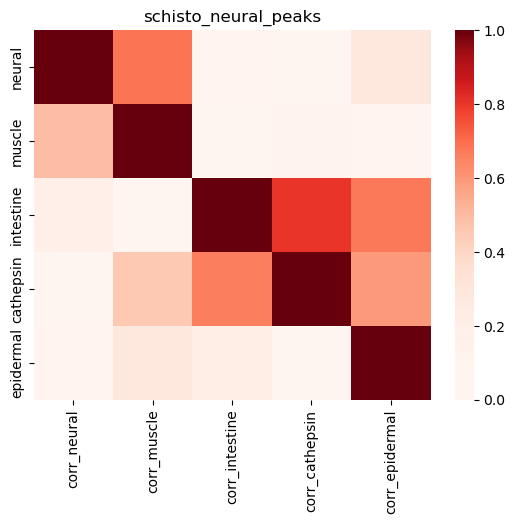

In [323]:
sns.heatmap(Sman_profile_normalized, annot=False,cmap=custom_cmap)
plt.title("schisto_neural_peaks")
plt.savefig("./Plots/Fig5/Panel5b_3.svg",format="svg")

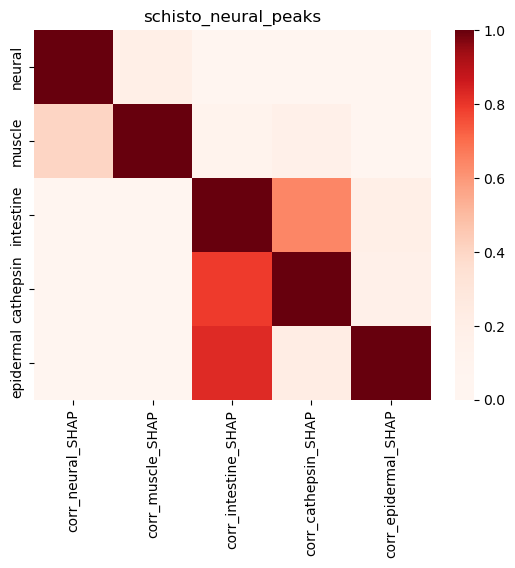

In [322]:
sns.heatmap(Sman_profile_SHAP_normalized, annot=False,cmap=custom_cmap)
plt.title("schisto_neural_peaks")
plt.savefig("./Plots/Fig5/Panel5b_4.svg",format="svg")

## Smed peaks Sman models

In [304]:
Smed_neural_median = Smed_neural_filtered.iloc[:,[0,1,2,3,4]].median()
Smed_muscle_median = Smed_muscle_filtered.iloc[:,[0,1,2,3,4]].median()
Smed_intestine_median = Smed_intestine_filtered.iloc[:,[0,1,2,3,4]].median()
Smed_epidermal_median = Smed_epidermal_filtered.iloc[:,[0,1,2,3,4]].median()
Smed_cathepsin_median = Smed_cathepsin_filtered.iloc[:,[0,1,2,3,4]].median()

Smed_neural_SHAP_median = Smed_neural_filtered.iloc[:,[5,6,7,8,9]].median()
Smed_muscle_SHAP_median = Smed_muscle_filtered.iloc[:,[5,6,7,8,9]].median()
Smed_intestine_SHAP_median = Smed_intestine_filtered.iloc[:,[5,6,7,8,9]].median()
Smed_epidermal_SHAP_median = Smed_epidermal_filtered.iloc[:,[5,6,7,8,9]].median()
Smed_cathepsin_SHAP_median = Smed_cathepsin_filtered.iloc[:,[5,6,7,8,9]].median()

In [310]:
Smed_profile_normalized = min_max_normalize_rows(Smed_profile)
Smed_profile_SHAP_normalized = min_max_normalize_rows(Smed_profile_SHAP)

In [309]:
Smed_profile = pd.DataFrame([Smed_neural_median, Smed_muscle_median, Smed_intestine_median, Smed_cathepsin_median,Smed_epidermal_median])
Smed_profile.index = ['neural','muscle','intestine','cathepsin','epidermal']
Smed_profile_SHAP = pd.DataFrame([Smed_neural_SHAP_median, Smed_muscle_SHAP_median, Smed_intestine_SHAP_median, Smed_cathepsin_SHAP_median,Smed_epidermal_SHAP_median])
Smed_profile_SHAP.index = ['neural','muscle','intestine','cathepsin','epidermal']


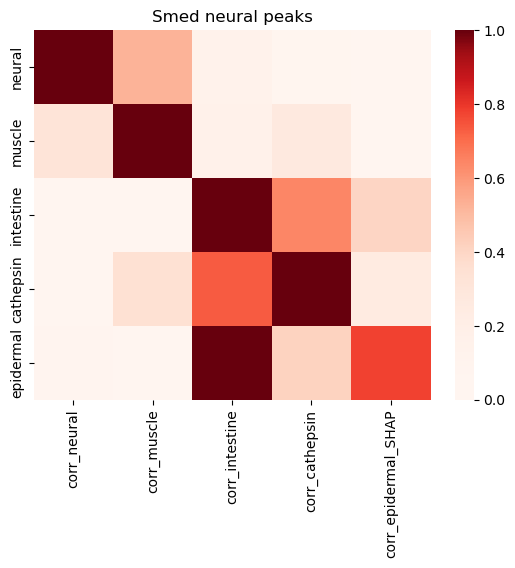

In [320]:
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list( 'custom',plt.get_cmap('Reds')(np.linspace(0,1,100)**(2)) )
sns.heatmap(Smed_profile_normalized, annot=False,cmap=custom_cmap)
plt.title("Smed neural peaks") 
plt.savefig("./Plots/Fig5/Panel5b_1.svg",format="svg")

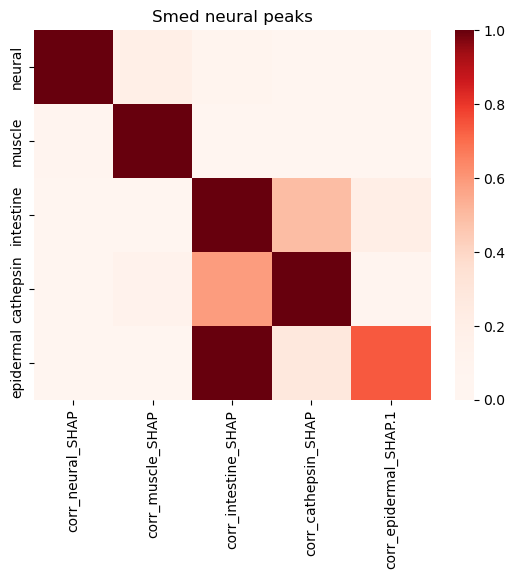

In [321]:
sns.heatmap(Smed_profile_SHAP_normalized, annot=False,cmap=custom_cmap)
plt.title("Smed neural peaks") 
plt.savefig("./Plots/Fig5/Panel5b_2.svg",format="svg")

## SHAP scores histogram

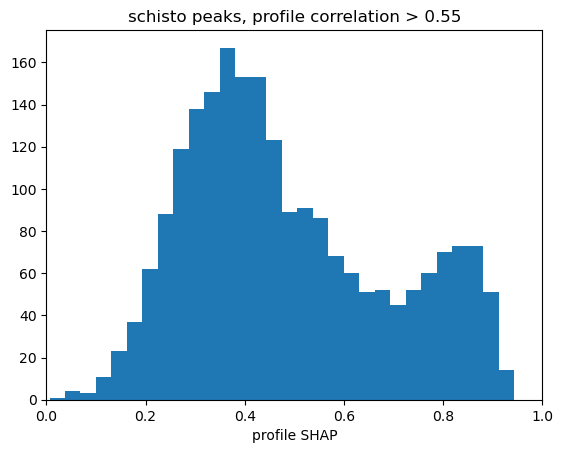

In [344]:
Sman_neural_bimodal = Sman_neural_all[Sman_neural_all.corr_neural >0.55]
plt.hist(Sman_neural_bimodal.corr_neural_SHAP,bins=30)
plt.xlim([0,1])
plt.title('schisto peaks, profile correlation > 0.55')
plt.xlabel('profile SHAP') 
plt.savefig('./Plots/Fig5/Panel5c_right.svg',format='svg')

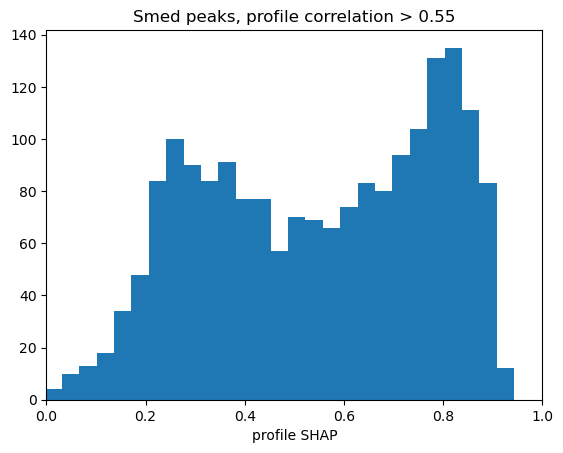

In [343]:
Smed_neural_bimodal = Smed_neural_filtered[Smed_neural_filtered.corr_neural >0.55]
plt.hist(Smed_neural_bimodal.corr_neural_SHAP,bins=30)
plt.xlim([0,1])
plt.title('Smed peaks, profile correlation > 0.55')
plt.xlabel('profile SHAP') 
plt.savefig('./Plots/Fig5/Panel5c_left.svg',format='svg')

## Examples for high correlation of both profile and SHAP 

### S.mediterranea peaks

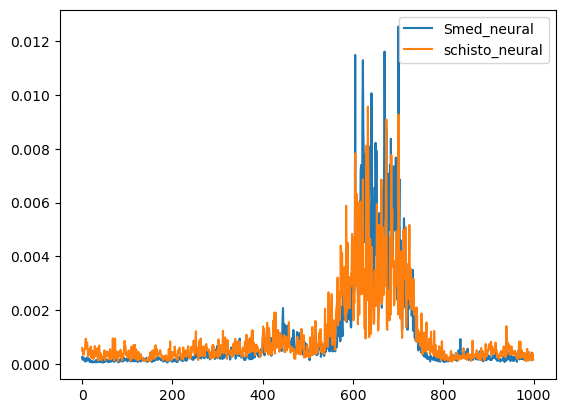

In [40]:
plt.plot(Smed_neural_probs[3052,:])
plt.plot(Sman_neural_probs[3052,:])
plt.legend(['Smed_neural','schisto_neural'])
plt.savefig('./Plots/Fig5/Panel5d_topleft.svg', format='svg')
plt.show()

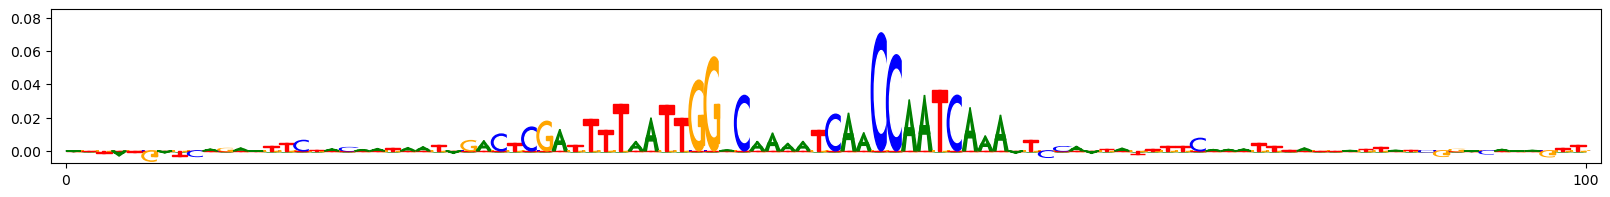

In [46]:
## Smed neural 
ind =  3052
start = 1170
end = 1270

max_score = Smed_neural_SHAP["projected_shap"]["seq"][ind][:,start:end].max()*1.2
min_score = Smed_neural_SHAP["projected_shap"]["seq"][ind][:,start:end].min()*1.2
ylim = (min_score,max_score)
plot_weights(Smed_neural_SHAP["projected_shap"]["seq"][ind][:,start:end], subticks_frequency=100,ylim=ylim,filename="./Plots/Fig5/Panel5d_topright.svg")

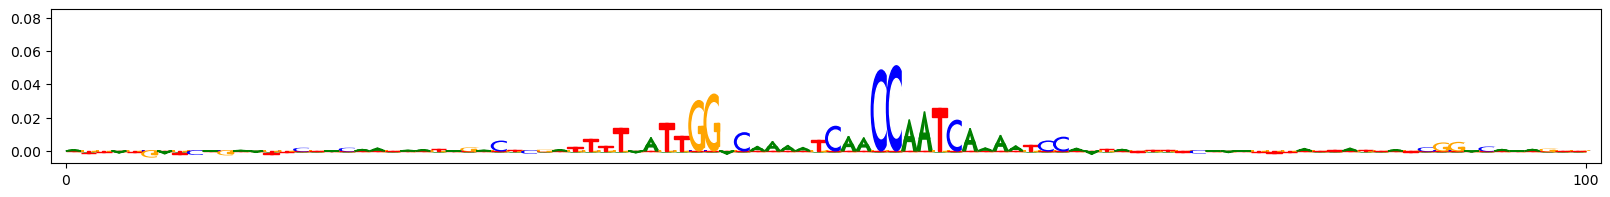

In [47]:
#Plot profile SHAP for schisto 
max_score = Smed_neural_SHAP["projected_shap"]["seq"][ind][:,start:end].max()*1.2
min_score = Smed_neural_SHAP["projected_shap"]["seq"][ind][:,start:end].min()*1.2
ylim = (min_score,max_score)
plot_weights(Sman_neural_SHAP["projected_shap"]["seq"][ind][:,start:end], subticks_frequency=100,ylim=ylim,filename="./Plots/Fig5/Panel5d_topright_2.svg")


### S. mansoni peaks

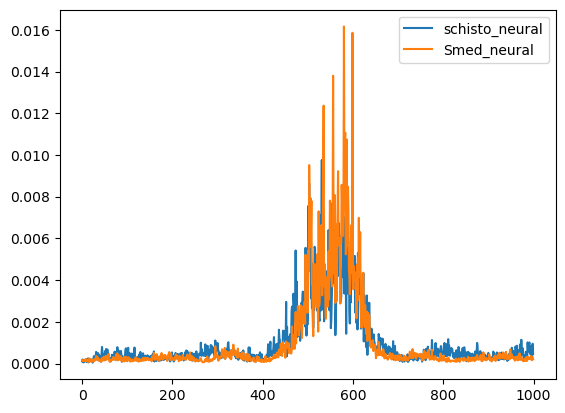

In [42]:
plt.plot(Sman_neural_probs[2818,:])
plt.plot(Smed_neural_probs[2818,:])
plt.legend(['schisto_neural','Smed_neural'])
plt.savefig('./Plots/Fig5/Panel5e_topleft.svg', format='svg')
plt.show()

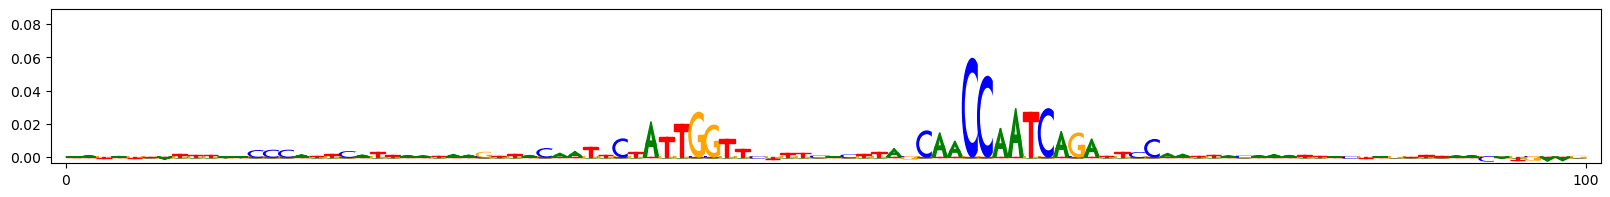

In [90]:
#Plot profile SHAP for schisto 

ind =  2818
start = 1050
end = 1150
max_score = Sman_neural_SHAP["projected_shap"]["seq"][ind][:,start:end].max()*1.5
min_score = Sman_neural_SHAP["projected_shap"]["seq"][ind][:,start:end].min()*1.5
ylim = (min_score,max_score)
plot_weights(Sman_neural_SHAP["projected_shap"]["seq"][ind][:,start:end], subticks_frequency=100,ylim=ylim,filename="./Plots/Fig5/Panel5e_topright.svg")


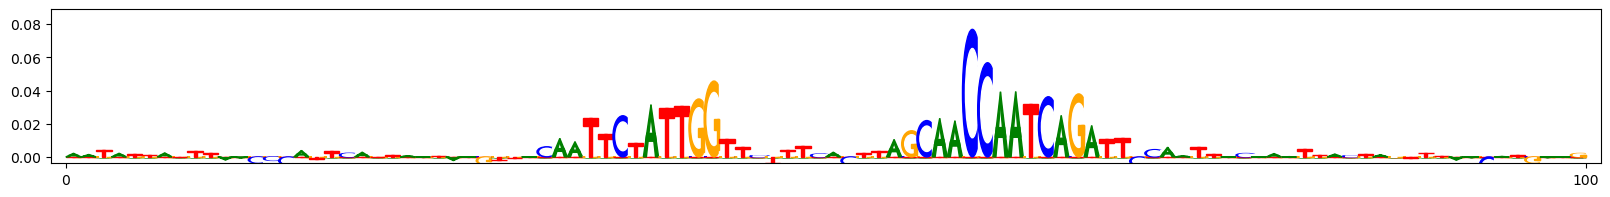

In [91]:
## Smed neural 
neural_SHAP = './SHAPscores/Smed/Smed_neural_schisto_neuralpeaks.profile_scores.h5'
neural_shap_scores = h5py.File(neural_SHAP,"r")
# input_len = 2114
max_score = Sman_neural_SHAP["projected_shap"]["seq"][ind][:,start:end].max()*1.5
min_score = Sman_neural_SHAP["projected_shap"]["seq"][ind][:,start:end].min()*1.5
ylim = (min_score,max_score)
plot_weights(Smed_neural_SHAP["projected_shap"]["seq"][ind][:,start:end], subticks_frequency=100,ylim=ylim,filename="./Plots/Fig5/Panel5e_topright_2.svg")

## Examples for high correlation of profile but low SHAP correlation

### S.mediterranea peaks

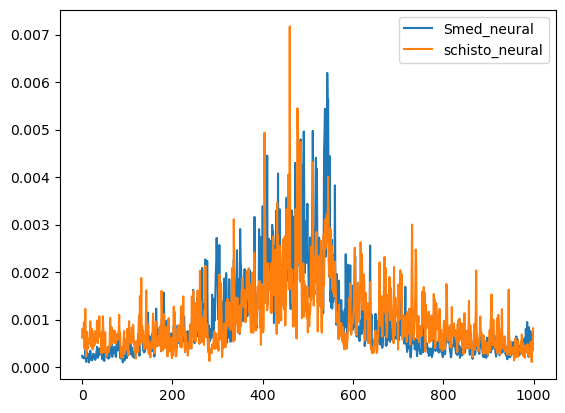

In [30]:
plt.plot(Smed_neural_probs[5074,:])
plt.plot(Sman_neural_probs[5074,:])
plt.legend(['Smed_neural','schisto_neural'])
plt.savefig('./Plots/Fig5/Panel5d_bottomleft.svg', format='svg')
plt.show()

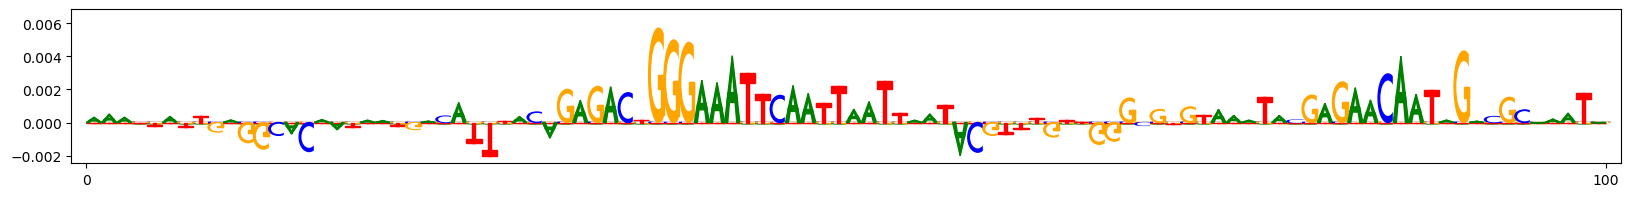

In [600]:
## Smed neural peaks 
ind =  5074
start = 925
end = 1025

max_score = Smed_neural_SHAP["projected_shap"]["seq"][ind][:,start:end].max()*1.2
min_score = Smed_neural_SHAP["projected_shap"]["seq"][ind][:,start:end].min()*1.2
ylim = (min_score,max_score)
plot_weights(Smed_neural_SHAP["projected_shap"]["seq"][ind][:,start:end], subticks_frequency=100,ylim=ylim,filename="./Plots/Fig5/Panel5d_bottomright.svg")

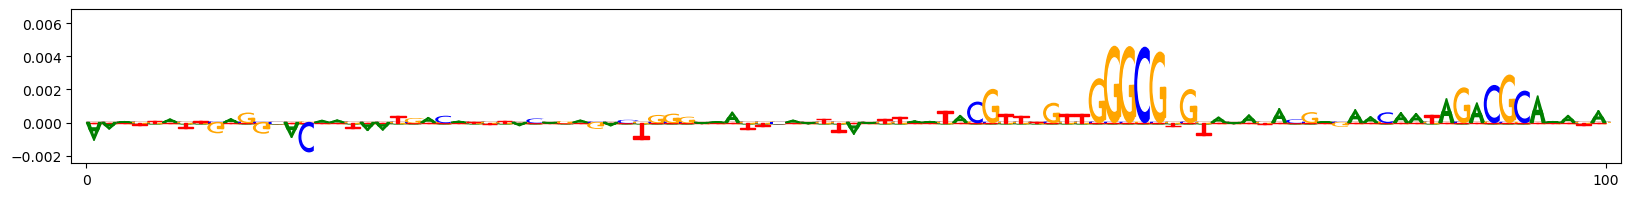

In [601]:
#Plot profile SHAP for schisto 
max_score = Smed_neural_SHAP["projected_shap"]["seq"][ind][:,start:end].max()*1.2
min_score = Smed_neural_SHAP["projected_shap"]["seq"][ind][:,start:end].min()*1.2
ylim = (min_score,max_score)
plot_weights(Sman_neural_SHAP["projected_shap"]["seq"][ind][:,start:end], subticks_frequency=100,ylim=ylim,filename="./Plots/Fig5/Panel5d_bottomright_2.svg")


### S. mansoni neural peaks

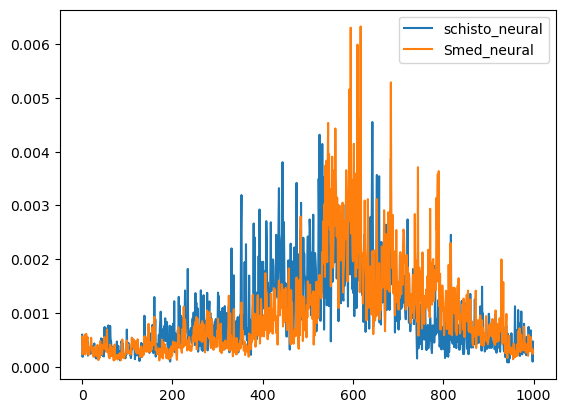

In [43]:
plt.plot(Sman_neural_probs[4468,:])
plt.plot(Smed_neural_probs[4468,:])
plt.legend(['schisto_neural','Smed_neural'])
plt.savefig('./Plots/Fig5/Panel5e_bottomleft.svg', format='svg')
plt.show()

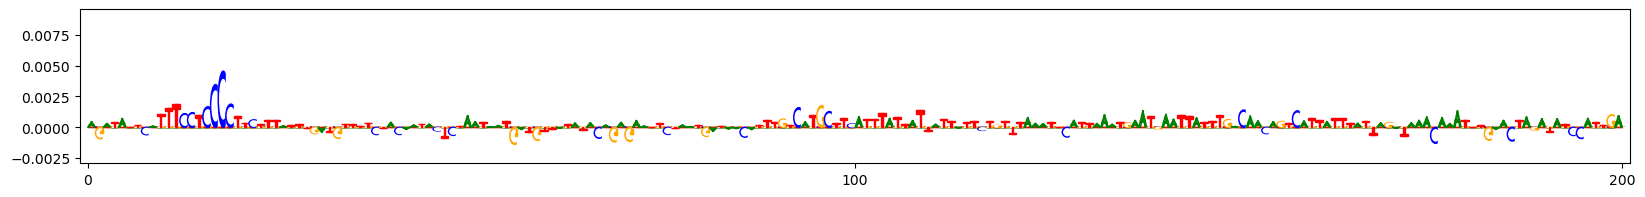

In [475]:
#Plot profile SHAP for schisto 
ind =  4486
start = 980
end = 1180
max_score = schisto_neural_shap_scores["projected_shap"]["seq"][ind][:,start:end].max()*2.1
min_score = schisto_neural_shap_scores["projected_shap"]["seq"][ind][:,start:end].min()*2.1
ylim = (min_score,max_score)
plot_weights(schisto_neural_shap_scores["projected_shap"]["seq"][ind][:,start:end], subticks_frequency=100,ylim=ylim,filename="./Plots/Fig5/Panel5e_bottomright.svg")


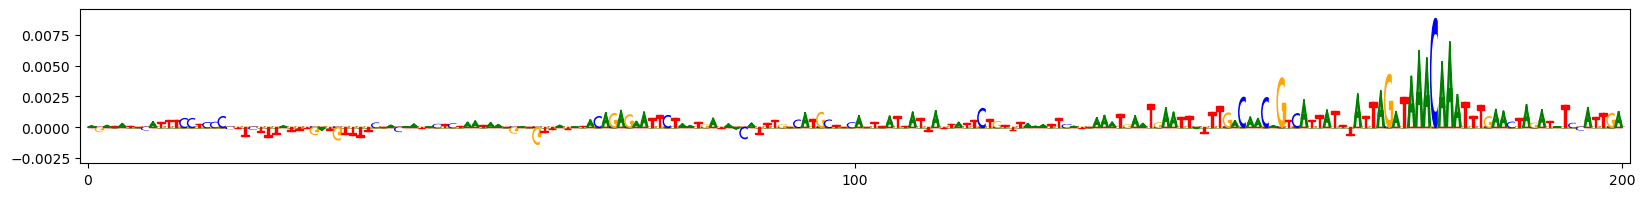

In [474]:
## Smed neural 
neural_SHAP = './SHAPscores/Smed/Smed_neural_schisto_neuralpeaks.profile_scores.h5'
neural_shap_scores = h5py.File(neural_SHAP,"r")
# input_len = 2114
max_score = schisto_neural_shap_scores["projected_shap"]["seq"][ind][:,start:end].max()*2.1
min_score = schisto_neural_shap_scores["projected_shap"]["seq"][ind][:,start:end].min()*2.1
ylim = (min_score,max_score)
plot_weights(neural_shap_scores["projected_shap"]["seq"][ind][:,start:end], subticks_frequency=100,ylim=ylim,filename="./Plots/Fig5/Panel5e_bottomright_2.svg")